In [1]:
import pandas as pd
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import RepeatedKFold
from functools import reduce
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, StratifiedKFold
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from sklearn.metrics import r2_score as R2
from skopt.space import Real, Categorical, Integer
from time import time
from skopt import BayesSearchCV
from functools import partial
import pprint

import warnings
warnings.filterwarnings('ignore')

from data_loader import load_datasets, nee_cumulative_to_daily, to_pd

In [2]:
target = 'NEE'

model = ['rcef_RandomForestRegressor', 'rcef_RidgeCV', 'rcef_XGBRegressor', 'xgboost'] 

extracted_features = model[-1]

In [3]:

dirs = ['warm_temp_maize_soybean_irrigated', 'warm_temp_maize-soybean_dryland', 'cool_temp_maize_soybean']

datasets = load_datasets(dirs, '/csv_outs/with_plant_soil_details/')

df_dry = nee_cumulative_to_daily(to_pd(datasets['warm_temp_maize-soybean_dryland'], True, True))
df_irr = nee_cumulative_to_daily(to_pd(datasets['warm_temp_maize_soybean_irrigated'], True, True))
df_cool = nee_cumulative_to_daily(to_pd(datasets['cool_temp_maize_soybean'], True, True))

df = pd.concat([df_dry,df_irr, df_cool])

y = df[target].copy()

In [4]:
xgbFeatImp = pd.read_csv('feature_analysis/xgboost/FeaturesImportance'  + target  + 'weather_soil_data' + '.csv')
feat_cols = []
for i in range(len(xgbFeatImp.values)):
    feat_cols.append(xgbFeatImp.values[i][0])

y = df[target].copy()
x = df[feat_cols]

In [5]:
observed_df = pd.read_csv('datasets/extractedNEE_CUT_REF_NIGHT.csv')

observed_df['initial planting density (m-2)1'] = 8.2
observed_df['DOY'] = observed_df['DOY'].astype(int)

x_observed = observed_df[feat_cols]
y_observed = observed_df['NEE']

In [6]:
x_concat = pd.concat([x, x_observed])
y_concat = pd.concat([y,y_observed])

#### Normalize using L2 regularization

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
   x_concat, y_concat, test_size=0.33, random_state=41)

In [8]:
def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [9]:
# Setting the scoring function
scoring = make_scorer(partial(MSE, squared=False), 
                      greater_is_better=False)


In [15]:
# Setting the basic regressor

#if gpu available 
#reg = xg.XGBRegressor(random_state=41, booster='gbtree', objective='reg:squarederror', tree_method='gpu_hist')

reg = xg.XGBRegressor(random_state=41, booster='gbtree', objective='reg:squarederror')
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)

# Setting the search space
search_spaces = {'learning_rate': Real(0.01, 1.0, 'uniform'),
                 'max_depth': Integer(2, 12),
                 'subsample': Real(0.1, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
                 'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
                 'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
                 'n_estimators': Integer(50, 5000)
   }

### Bayesian optimiser

In [16]:
#fix deprecated stuff*
np.int = np.int64

In [ ]:
# Wrapping everything up into the Bayesian optimizer
opt = BayesSearchCV(estimator=reg,                                    
                    search_spaces=search_spaces,                      
                    scoring=scoring,                                  
                    cv=cv,                                           
                    n_iter=120,                                       # max number of trials
                    n_points=1,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=1,                                         # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=41)                                   # random state for replicability

# Running the optimizer
overdone_control = DeltaYStopper(delta=0.0001)                    # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60*60*4)          # We impose a time limit (7 hours)

best_params = report_perf(opt,x_concat, y_concat, 'XGBoost_regression', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
# Transferring the best parameters to our basic regressor
reg =xg.XGBRegressor(random_state=0, booster='gbtree', objective='reg:squarederror', **best_params)

In [ ]:
reg.fit(X_train, y_train)

In [ ]:
# Predict the model
pred = reg.predict(X_test)

In [ ]:
# Calculate R2 score
r2 = R2(y_test, pred)

rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))

# Create scatter plot
plt.scatter(y_test, pred)

# Plot a red line for perfect accuracy
x = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x, x, color='r')

# Add title and legend
plt.title("XGB Predicted " + target +  " using bayesian pretrained, grid search fine tuned xgb model  (R2 = %0.2f  RMSE  = %0.4f)" %  (r2, rmse))
plt.legend(['Predictions', 'Perfect accuracy'], loc='upper left')
plt.xlabel("Predicted NEE g C m-2 day-1")
plt.ylabel("Observed NEE g C m-2 day-1")

#plt.savefig("results/bayesian pretrained, grid search fine tuned xgb model  " + target + "with_planting_details.png" )
# Show plot
plt.show()

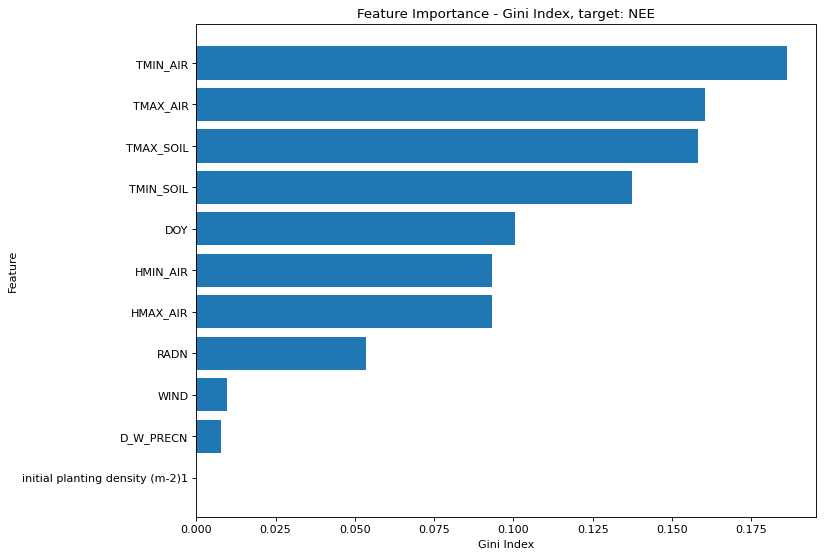

In [ ]:
importances = pd.DataFrame({'GINI': reg.feature_importances_}, index=X_train.columns).sort_values(by='GINI', ascending=True)

# Create a horizontal bar chart
plt.figure(figsize=(10, 8), dpi=80)
plt.barh(importances.index, importances['GINI'])

# Add title and axis labels
plt.title('Feature Importance - Gini Index, NEE g C m-2 day-1')
plt.xlabel('Gini Index')
plt.ylabel('Feature')

plt.savefig('results/HyperParamFeatureImportanceGiniIndex' + target + "with_planting_details.png")
# Show the plot
plt.show()

In [21]:
import pickle
file_name = "models/observed_data.pkl"

# save
pickle.dump(reg, open(file_name, "wb"))
reg.save_model('models/simulated_with_daily_nee.json')

In [8]:
hyper_params = ['colsample_bytree','learning_rate','max_depth','reg_alpha','reg_lambda','subsample']

In [ ]:
simulated_xg = xg.XGBRegressor()
simulated_xg.load_model("models/xgb_reg.json")

In [ ]:
X_train_sim, X_test_sim, y_train_sim, y_test_sim = train_test_split(
   x, y, test_size=0.33, random_state=41)

In [19]:
X_train_obs, X_test_obs, y_train_obs, y_test_obs = train_test_split(
   x_observed, y_observed, test_size=0.33, random_state=41)

In [20]:
X_train_sim

,TMAX_AIR,TMAX_SOIL,TMIN_AIR,D_W_PRECN,WIND,HMAX_AIR,HMIN_AIR,TMIN_SOIL,RADN,initial planting density (m-2)1,DOY
1313,0.016805,0.000537,0.017947,0.042794,0.007042,0.016914,0.018908,0.000502,0.014573,0.012417,0.011016
1883,0.000540,0.000090,-0.014976,0.000000,0.009074,0.004553,0.001832,0.000069,0.010760,0.009389,0.002913
1057,0.007622,-0.018448,0.008098,0.000162,0.007092,0.009505,0.010939,0.018514,0.004663,0.009995,0.016536
730,0.003199,0.000118,-0.005845,0.000000,0.007870,0.005571,0.003943,0.000083,0.004677,0.009389,0.018512
1331,0.018660,0.000529,0.018991,0.000000,0.006589,0.019404,0.020280,0.000495,0.013208,0.012417,0.011928
...,...,...,...,...,...,...,...,...,...,...,...
2669,0.011405,-0.018386,0.004468,0.000000,0.004607,0.007021,0.008091,0.018478,0.015015,0.009995,0.005699
2278,0.005118,0.000246,-0.001899,0.000162,0.025748,0.006073,0.005398,0.000120,0.011044,0.012417,0.004382
1144,-0.006643,0.000077,-0.021008,0.000000,0.004885,0.001732,0.001069,0.000056,0.010312,0.012417,0.002457
931,0.019761,0.000758,0.022749,0.000000,0.009606,0.019323,0.018608,0.000625,0.015596,0.009389,0.010155


In [24]:
X_train = pd.concat([X_train_sim, X_train_obs])
X_test = pd.concat([X_test_sim, X_test_obs])
Y_train = pd.concat([y_train_sim, y_train_obs])
Y_test = pd.concat([y_test_sim, y_test_obs])

In [27]:
reg = xg.XGBRegressor()
reg.load_model("models/bayesian_pretrain_gridsearch_fine_tune_xgb.json")

In [11]:
cross_val_params = {}

for param in hyper_params:
    sim_par = simulated_xg.get_xgb_params()[param]
    obs_par = observed_xg.get_xgb_params()[param]
    if (sim_par == obs_par):
        cross_val_params[param] = [sim_par]
    else:
        cross_val_params[param] = [sim_par,obs_par]
        
sim_n = simulated_xg.get_params(deep=True)['n_estimators']
obs_n = observed_xg.get_params(deep=True)['n_estimators']

if (sim_n==obs_n):
    cross_val_params['n_estimators'] = [sim_n]
else:
    cross_val_params['n_estimators'] = [sim_n, obs_par]

In [17]:
reg = xg.XGBRegressor(random_state=41, booster='gbtree', objective='reg:squarederror')

grid_search = GridSearchCV(estimator=reg, 
                           param_grid=cross_val_params, 
                           scoring=scoring, 
                           refit=False, 
                           n_jobs=-1, 
                           cv=cv,  
                           verbose=0)

best_params = report_perf(grid_search, x_merged, y_merged)

model took 1093.59 seconds,  candidates checked: 16, best CV score: -0.004 ± 0.004
Best parameters:
{'colsample_bytree': 1.0,
 'learning_rate': 0.01,
 'max_depth': 12,
 'n_estimators': 5000,
 'reg_alpha': 1e-09,
 'reg_lambda': 100.0,
 'subsample': 0.7282316492848115}



In [18]:
# Transferring the best parameters to our basic regressor
reg =xg.XGBRegressor(random_state=0, booster='gbtree', objective='reg:squarederror', **best_params)

In [ ]:
reg = xg.XGBRegressor()
reg.load_model("models/observed_data.json")

In [28]:
reg.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float'],
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [29]:
# Predict the model
pred = reg.predict(X_test)

RMSE :  0.002163


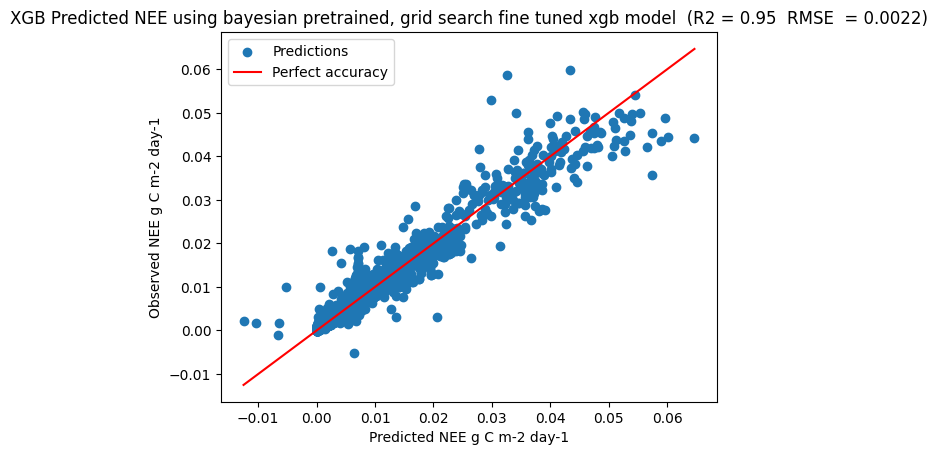

In [33]:
# Calculate R2 score
r2 = R2(Y_test, pred)

rmse = np.sqrt(MSE(Y_test, pred))
print("RMSE : % f" %(rmse))

# Create scatter plot
plt.scatter(Y_test, pred)

# Plot a red line for perfect accuracy
x = np.linspace(min(Y_test), max(Y_test), 100)
plt.plot(x, x, color='r')

# Add title and legend
plt.title("XGB Predicted " + target +  " using bayesian pretrained, grid search fine tuned xgb model  (R2 = %0.2f  RMSE  = %0.4f)" %  (r2, rmse))
plt.legend(['Predictions', 'Perfect accuracy'], loc='upper left')
plt.xlabel("Predicted NEE g C m-2 day-1")
plt.ylabel("Observed NEE g C m-2 day-1")

plt.savefig("results/bayesian pretrained, grid search fine tuned xgb model  " + target + "with_planting_details.png" )
# Show plot
plt.show()

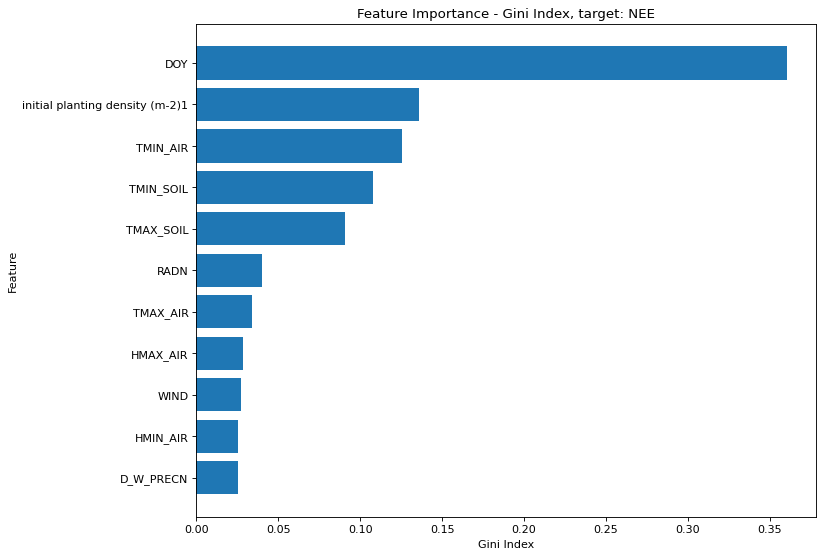

In [34]:
importances = pd.DataFrame({'GINI': reg.feature_importances_}, index=X_train.columns).sort_values(by='GINI', ascending=True)

# Create a horizontal bar chart
plt.figure(figsize=(10, 8), dpi=80)
plt.barh(importances.index, importances['GINI'])

# Add title and axis labels
plt.title('Feature Importance - Gini Index, target: NEE')
plt.xlabel('Gini Index')
plt.ylabel('Feature')

plt.savefig('results/featureImpBayesianpretrainedgridsearchfinetunedxgbmodel' + target + "with_planting_details.png")
# Show the plot
plt.show()

In [34]:
import pickle
file_name = "models/bayesian_pretrain_gridsearch_fine_tune_xgb.pkl"

# save
pickle.dump(reg, open(file_name, "wb"))
reg.save_model('models/bayesian_pretrain_gridsearch_fine_tune_xgb.json')